In [85]:
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta, date
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import os
from scipy import linalg
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mapping_tickers import *

In [2]:
tk = 'AAPL'
end_date = datetime.today()
start_date = datetime(end_date.year - 1, end_date.month, end_date.day)

df_adj_close = pd.DataFrame()
data = yf.download(tk, start=start_date, end=end_date)
df_adj_close[tk] = data['Adj Close']
display(data)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-30,184.940002,187.850006,184.740005,187.649994,186.694656,60813900
2023-08-31,187.839996,189.119995,187.479996,187.869995,186.913544,60794500
2023-09-01,189.490005,189.919998,188.279999,189.460007,188.495453,45732600
2023-09-05,188.279999,189.979996,187.610001,189.699997,188.734222,45280000
2023-09-06,188.399994,188.850006,181.470001,182.910004,181.978790,81755800
...,...,...,...,...,...,...
2024-08-23,225.660004,228.220001,224.330002,226.839996,226.839996,38677300
2024-08-26,226.759995,227.279999,223.889999,227.179993,227.179993,30602200
2024-08-27,226.000000,228.850006,224.889999,228.029999,228.029999,35934600


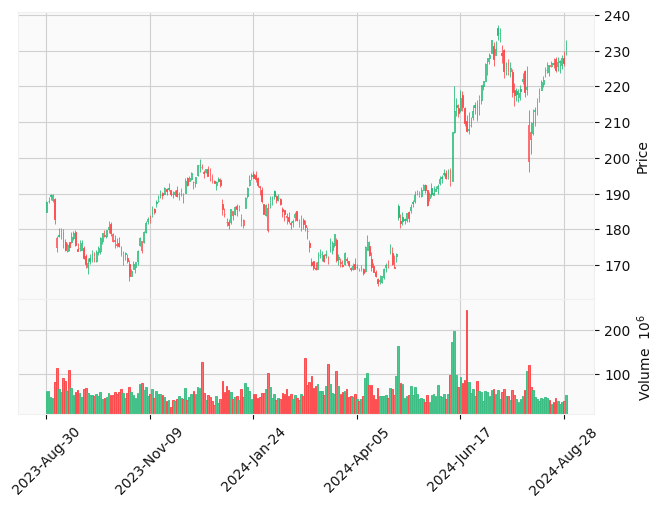

In [3]:
# mpf.plot(aapl, volume=True, style='yahoo', type='candle')
mpf.plot(data, volume=True, style='yahoo', type='hollow_and_filled')

How to combine matplotlib axes with mpl_finance plot? See https://github.com/matplotlib/mplfinance/blob/master/examples/external_axes.ipynb

In [4]:
def set_axis_limits(x_min, x_max):
    """
    Returns the lower and upper limits for an axis where x_min and x_max are the min/max values.
    units: increments of values at axis ticks, will be scaled to correspond with the
        order of magntitude of x_max - x_min
    intervals: how many intervals of units between the lower and the upper limit do we want to have
    """

    if x_min == x_max:
        return x_min, x_max
    
    else:
        units = np.array([0.05, 0.1, 0.2, 0.25, 0.5])
        intervals = np.array([4, 5, 6, 7, 8, 9])
        max_n_intervals = max(intervals)

        x_maxmax = max(abs(x_max), abs(x_min))
        diff = 2 * x_maxmax
        order = 10 ** round(math.log10(x_maxmax))
        # print(f'order = {order}')
        eps = order * 1e-10

        for unit in units:
            unit_scaled = order * unit
            # print(f'unit scaled = {unit_scaled}')

            lower_anchor = 0
            increment = unit_scaled
            while lower_anchor - abs(x_min) < eps:
                lower_anchor += increment
            lower_anchor *= np.sign(x_min)
            if x_min > eps:
                lower_anchor -= increment

            diff_lower = abs(lower_anchor - x_min)
            if diff_lower < eps:
                diff_lower = 0

            # print(f'\tlower anchor = {lower_anchor}')
            # print(f'\tdiff lower = {diff_lower}')

            upper_anchor = lower_anchor
            while (upper_anchor < x_max) & (abs(upper_anchor - x_max) > eps) & ((upper_anchor - lower_anchor) / unit_scaled <= max_n_intervals):
                upper_anchor += unit_scaled
                # print(f'\tupper anchor = {upper_anchor}')
            diff_upper = abs(upper_anchor - x_max)
            if diff_upper < eps:
                diff_upper = 0
            
            # print(f'\tupper anchor = {upper_anchor}')
            # print(f'\tdiff upper = {diff_upper}')

            if (upper_anchor - x_max > -eps) & (diff_lower + diff_upper < diff):
                diff = diff_lower + diff_upper
                lower_limit = lower_anchor
                upper_limit = upper_anchor
        
        return lower_limit, upper_limit

In [5]:
def plot_candlestick(
    tk,
    df,
    start_date,
    end_date,
    title=None,
    y_min=None,
    y_max=None,
    color=None,
    x_dim=12,
    y_dim=8,
    grid='both'
):
    """
    Create a plot of a historical profile
    tk: ticker profile to be plotted
    df: dataframe containing data for ticker tk
    """

    """
    if isinstance(df, pd.Series):
        df_tk = df.copy()
    elif isinstance(df, pd.DataFrame):
        df_tk = df[tk]
    else:
        print('df must a a series or a dataframe')
        exit
    """

    if title is None:
        title = tk
    if color is None:
        color = 'tab:blue'  # same as '#1f77b4'

    # Set x-axis limits
    if isinstance(start_date, datetime):
        x_min = str(start_date.date())
    elif isinstance(start_date, date):
        x_min = str(start_date)
    elif isinstance(start_date, str):
        x_min = start_date
    else:
        print('Incorrect format of start_date')
        exit

    if isinstance(end_date, datetime):
        x_max = str(end_date.date())
    elif isinstance(end_date, date):
        x_max = str(end_date)
    elif isinstance(end_date, str):
        x_max = end_date
    else:
        print('Incorrect format of end_date')
        exit

    if x_min not in data.index:
        while x_min not in data.index:
            new_start_date = datetime.strptime(x_min, '%Y-%m-%d') + timedelta(1)
            x_min = str(new_start_date.date())

    if x_max not in data.index:
        while x_max not in data.index:
            new_end_date = datetime.strptime(x_max, '%Y-%m-%d') - timedelta(1)
            x_max = str(new_end_date.date())

    print(f'x_min, x_max = {x_min, x_max}')

    y_lower, y_upper = set_axis_limits(min(data['Low']), max(data['High']))
    if y_min is None:
        y_min = y_lower
    if y_max is None:
        y_max = y_upper
    print(y_min, y_max)

    # Set tick spacing based on the total number of date points
    n_ticks_max = 36
    cond_start = data.index >= x_min
    cond_end = data.index <= x_max
    n = len(data.loc[cond_start & cond_end])
    tick_spacing = max(1, round(n / n_ticks_max))

    fig = mpf.figure(figsize=(x_dim, y_dim), style='yahoo')
    ax = fig.add_subplot(1, 1, 1)

    print(f'dir(ax):\n{dir(ax)}')
    print(f'dir(ax.set_xticks):\n{dir(ax.set_xticks)}')
    print(f'dir(ax.get_xticks):\n{dir(ax.get_xticks)}')
    print(f'dir(ax.get_xgridlines):\n{dir(ax.get_xgridlines)}')

    mpf.plot(
        data,
        ax=ax,
        volume=False,
        style='yahoo',
        type='hollow_and_filled',
        datetime_format='%Y-%m-%d',
        xlim=(x_min, x_max),
        ylim=(y_min, y_max),
        xrotation=90
    )

    ax.set_title(title)
    # ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    # plt.xlabel('Date')
    # ax.get_xticks()
    # ax.set_xticks()

    if grid in ['x', 'both']:
        ax.get_xgridlines()
    if grid in ['y', 'both']:
        ax.get_ygridlines()

    # ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

    return fig


x_min, x_max = ('2023-08-30', '2024-08-29')
160.0 240.0
dir(ax):
['ArtistList', '_AxesBase__clear', '_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_text', '_adjustable', '_agg_filter', '_alias_map', '_alpha', '_anchor', '_animated', '_aspect', '_autotitlepos', '_axes', '_axes_locator', '_axis_map', '_axis_names', '_axisbelow', '_box_aspect', '_callbacks', '_check_no_units', '_children', '_clipon', '_clippath', '_cm_set', '_colorbars', '_convert_dx', '_current_image', '_default_contains', '_errorevery_to_mask', '_facecolor', '_fill_between_x_or_y', '_frameon', '_fully_clipped_to_axes', '_gci', '_gen_axes_patch', '_gen_axes_spi

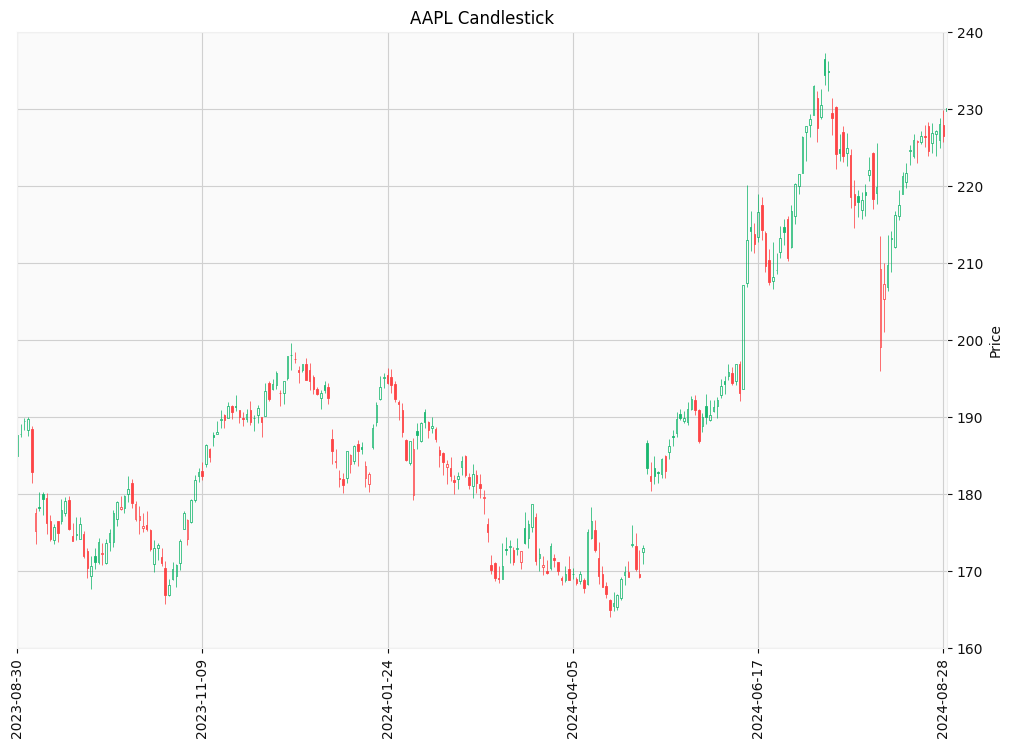

In [6]:
title_candles = f'{tk} Candlestick'
plot_candles = plot_candlestick(
    tk,
    data,
    start_date,
    end_date,
    title_candles
 )

Bollinger Bands

In [7]:
def bollinger_bands(prices, window=20, n_std=2):
    """
    prices: series or dataframe of ticker prices, could be adj_close or any of the open, high, low, close (ohlc)
    window: size of the rolling window in days, defaults to 20
    n_sd: width of each band in standard deviations, defaults to 2
    returns: dictionary boll_bands = {
            'upper': upper_band,
            'lower': lower_band
        }
    """
 
    df_sma = prices.rolling(window=window, min_periods=1).mean()
    df_std = prices.rolling(window=window, min_periods=1).std(ddof=0)

    upper_band = df_sma + n_std * df_std
    lower_band = df_sma - n_std * df_std

    boll_bands = {
        'upper': upper_band,
        'lower': lower_band
    }

    return boll_bands

Hollow Candles - see e.g. https://trendspider.com/learning-center/understanding-hollow-candles-the-basics/

In [84]:
fig = make_subplots(
    rows = 1,
    cols = 1
)
ohlc = data.copy()
df = ohlc

df_10d_sma = ohlc['Close'].rolling(window=10, min_periods=1).mean()
df_20d_sma = ohlc['Close'].rolling(window=20, min_periods=1).mean()
df_30d_sma = ohlc['Close'].rolling(window=30, min_periods=1).mean()

ohlc['Date'] = ohlc.index.astype(str)

ohlc['previousClose'] = ohlc['Close'].shift(1)

# Define color based on close and previous close
ohlc['color'] = np.where(ohlc['Close'] > ohlc['previousClose'], 'green', 'red')

# Set fill to transparent if close > open and the previously defined color otherwise
ohlc['fill'] = np.where(ohlc['Close'] > ohlc['Open'], 'rgba(255, 0, 0, 0)', ohlc['color'])


shown_red_fill = False
shown_red_hollow = False
shown_green_fill = False
shown_green_hollow = False

for index, row in ohlc.iterrows():
    
    if (row['color'] == 'green') & (row['fill'] == 'green'):
        name = 'Open > Close > Prev Close'
        current_candle = 'green_fill'
    elif (row['color'] == 'green') & (row['fill'] == 'rgba(255, 0, 0, 0)'):
        name = 'Prev Close < Close > Open'
        current_candle = 'green_hollow'
    elif (row['color'] == 'red') & (row['fill'] == 'red'):
        name = 'Open > Close < Prev Close'
        current_candle = 'red_fill'
    elif (row['color'] == 'red') & (row['fill'] == 'rgba(255, 0, 0, 0)'):
        name = 'Prev Close > Close > Open'
        current_candle = 'red_hollow'
    else:
        name = 'Hollow Candles'
            
    # print(f'{str(index.date())}, {row["color"]}, {row["fill"]}, {current_candle}, {name}')

    if ~shown_green_fill & (current_candle == 'green_fill'):
        showlegend = True
        shown_green_fill = True
    elif ~shown_green_hollow & (current_candle == 'green_hollow'):
        showlegend = True
        shown_green_hollow = True
    elif ~shown_red_fill & (current_candle == 'red_fill'):
        showlegend = True
        shown_red_fill = True
    elif ~shown_red_hollow & (current_candle == 'red_hollow'):
        showlegend = True
        shown_red_hollow = True
    else:
        showlegend = False

    color_dict = dict(fillcolor=row['fill'], line=dict(color=row['color']))
    
    fig.add_trace(
        go.Candlestick(
            x = [row['Date']],
            open = [row['Open']],
            high = [row['High']],
            low = [row['Low']],
            close = [row['Close']],
            increasing = color_dict,
            decreasing = color_dict,
            showlegend = showlegend,
            name = name,
            legendgroup = 'Hollow Candlesticks'
        )
    )

fig.add_trace(
    go.Scatter(
        x = ohlc['Date'],
        y = df_20d_sma,
        line = {'color': 'lemonchiffon'},  # or 'palegoldenrod' - slightly darker
        name = '20-Day SMA'
    )
)

# Add Bollinger bands
upper_bollinger_close = bollinger_bands(df['Close'])['upper']
lower_bollinger_close = bollinger_bands(df['Close'])['lower']
fig.add_trace(
    go.Scatter(
        x = df['Date'],
        y = lower_bollinger_close,
        line = dict(color='gold'),
        # name = '2-SD Bollinger Bands'
        name = '(20, 2) Bollinger Bands'
    )
)
fig.add_trace(
    go.Scatter(
        x = df['Date'],
        y = upper_bollinger_close,
        line = dict(color='gold'),
        showlegend = False
    )
)
"""
fig.add_trace(
    go.Scatter(
        x = ohlc['Date'],
        y = df_30d_sma,
        line = {'color': 'palegoldenrod'},  # or 'khaki' - slightly darker
        name = '30-Day SMA'
    )
)
"""

fig.update_layout(
    width = 1600,
    height = 800,
    xaxis_rangeslider_visible = False,
    template = 'plotly_dark',
    yaxis_title = f'Price',
    title = dict(
        text = f'{tk} Prices - Hollow Candles',
        font_size = 32,
        y = 0.95,
        x = 0.45,
        xanchor = 'center',
        yanchor = 'top'
    )
)
fig.update_xaxes(
    nticks = 36,
    tickformat = '%Y-%m-%d',
    type = 'category',
    tickangle = -90
)

fig.show()

In [82]:
fig = make_subplots(
    rows = 1,
    cols = 1
)

df = data.copy()
display(df)
n_ticks_max = 32

df_15dma_close = df['Close'].rolling(window=15, min_periods=1).mean()
df_20dma_close = df['Close'].rolling(window=20, min_periods=1).mean()
df_30dma_close = df['Close'].rolling(window=30, min_periods=1).mean()
df_15dma_adjclose = df['Adj Close'].rolling(window=15, min_periods=1).mean()
df_20dma_adjclose = df['Adj Close'].rolling(window=20, min_periods=1).mean()
df_30dma_adjclose = df['Adj Close'].rolling(window=30, min_periods=1).mean()

df['Date'] = df.index.astype(str)

# n = len(df)
# x_tick_spacing = max(1, round(n / n_ticks_max))
# print(n, x_tick_spacing)
# x_dtick = 86400000 * x_tick_spacing  # convert days to milliseconds

shown_green = False
shown_red = False

for index, row in df.iterrows():
    
    if row['Close'] >= row['Open']:
        color_dict = dict(fillcolor='rgba(0, 255, 0, 0.3)', line=dict(color='green'))
        name = 'Close > Open'
        current_candle = 'green'
    else:
        color_dict = dict(fillcolor='rgba(255, 0, 0, 0.6)', line=dict(color='red'))
        name = 'Open > Close'
        current_candle = 'red'

    if ~shown_green & (current_candle == 'green'):
        showlegend = True
        shown_green = True
    elif ~shown_red & (current_candle == 'red'):
        showlegend = True
        shown_red = True
    else:
        showlegend = False

    # print(f'{str(index.date())}, {row["Open"]}, {row["Close"]}, {current_candle}, {name}')

    fig.add_trace(
        go.Candlestick(
            x = [row['Date']],
            open = [row['Open']],
            high = [row['High']],
            low = [row['Low']],
            close = [row['Close']],
            name = name,
            increasing = color_dict,
            decreasing = color_dict,
            showlegend = showlegend
        )
    )
    """
    fig.add_trace(
        go.Scatter(
            x = df['Date'],
            y = df_15dma_close,
            line = dict(color='gold'),        
            name = '15-Day SMA'
        )
    )
    fig.add_trace(
        go.Scatter(
            x = df['Date'],
            y = df_30dma,
            line = dict(color='palegoldenrod'),  # 'khaki' - slightly darker
            name = '30-Day SMA'
        )
    )
    """

fig.add_trace(
    go.Scatter(
        x = df['Date'],
        y = df_20dma_close,
        line = {'color': 'lemonchiffon'},  # or 'palegoldenrod' - slightly darker
        name = '20-Day SMA'
    )
)

# Add Bollinger bands
upper_bollinger_adjclose = bollinger_bands(df['Adj Close'])['upper']
lower_bollinger_adjclose = bollinger_bands(df['Adj Close'])['lower']
upper_bollinger_close = bollinger_bands(df['Close'])['upper']
lower_bollinger_close = bollinger_bands(df['Close'])['lower']
fig.add_trace(
    go.Scatter(
        x = df['Date'],
        y = lower_bollinger_close,
        line = dict(color='gold'),  # gold
        # name = '2-SD Bollinger Bands'
        name = '(20, 2) Bollinger Bands'
    )
)
fig.add_trace(
    go.Scatter(
        x = df['Date'],
        y = upper_bollinger_close,
        line = dict(color='gold'),
        showlegend = False
    )
)
"""
fig.add_trace(
    go.Scatter(
        x = df['Date'],
        y = lower_bollinger_adjclose,
        line = dict(color='orange'),  # gold
        name = '2-SD Bollinger Bands (Adj Close)'
    )
)
fig.add_trace(
    go.Scatter(
        x = df['Date'],
        y = upper_bollinger_adjclose,
        line = dict(color='orange'),
        showlegend = False
    )
)
"""
fig.update_layout(
    width = 1450,
    height = 725,
    xaxis_rangeslider_visible = False,
    template = 'plotly_dark',
    yaxis_title = f'Price',
    title = dict(
        text = f'{tk} Prices - Traditional Candles',
        font_size = 32,
        y = 0.95,
        x = 0.45,
        xanchor = 'center',
        yanchor = 'top'
    )
)
fig.update_xaxes(
    # tickformat = "%Y-%m-%d",
    type = 'category',
    nticks = n_ticks_max,
    tickangle = -90,
)

fig.show()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-30,184.940002,187.850006,184.740005,187.649994,186.694656,60813900
2023-08-31,187.839996,189.119995,187.479996,187.869995,186.913544,60794500
2023-09-01,189.490005,189.919998,188.279999,189.460007,188.495453,45732600
2023-09-05,188.279999,189.979996,187.610001,189.699997,188.734222,45280000
2023-09-06,188.399994,188.850006,181.470001,182.910004,181.978790,81755800
...,...,...,...,...,...,...
2024-08-23,225.660004,228.220001,224.330002,226.839996,226.839996,38677300
2024-08-26,226.759995,227.279999,223.889999,227.179993,227.179993,30602200
2024-08-27,226.000000,228.850006,224.889999,228.029999,228.029999,35934600
